In [3]:
# import things
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from statistics import mean, median


%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [5]:
# load data from 3 input files
# import data

# BAR302 #
#########################################################
# "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/BAR302/29dec/true_rev_lengths.h5"
# "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/BAR302/29dec/data_df.h5"


# HIM-5 #
#########################################################
##corrected him-5
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/him5/output_current_him5/him5_29dec_newmockdata/data_df.h5",
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/him5/output_current_him5/him5_29dec_newmockdata/true_rev_lengths.h5",
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_29dec_newmockdata/gf_per_worm.xlsx"

##uncorrected him-5
# "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_20feb_formillyuncorrheatmaps/data_df_HIM-5.h5"
# "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_20feb_formillyuncorrheatmaps/true_rev_lengths_HIM-5.h5",
# "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_20feb_formillyuncorrheatmaps/gf_per_worm_HIM-5.xlsx"

#########################################################

data_df_OG = pd.read_hdf(
    "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_29dec_newmockdata/data_df.h5",
    "/df",
)
all_rev_lengths_OG = pd.read_hdf(
    "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_29dec_newmockdata/true_rev_lengths.h5",
    "/df",
)

# this one is the same sheared or not
gf_per_worm = pd.read_excel(
    "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/output_current_him5/him5_29dec_newmockdata/gf_per_worm.xlsx"
)


# # import data SHEARED VERSIONS

# s30_data_df = pd.read_hdf(
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/analysis/s30_data_df.h5",
#     "/df",
# )
# s30_all_rev_lengths = pd.read_hdf(
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/analysis/s30_all_rev_lengths.h5",
#     "/df",
# )

# s50_data_df = pd.read_hdf(
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/analysis/s50_data_df.h5",
#     "/df",
# )
# s50_all_rev_lengths = pd.read_hdf(
#     "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/analysis/s50_all_rev_lengths.h5",
#     "/df",
# )

## functions

### function to get np array and df of speed

In [9]:
def get_np_array_speed(data_df, these_worms, Ncond):
    max_framenumber = data_df["frame_number"][
        data_df["unique_id"].isin(these_worms)
    ].max()

    these_worms_speed = data_df[["unique_id", "frame_number", "speed"]][
        data_df["unique_id"].isin(these_worms)
    ]

    # create empty numpy array to hold speed/framenumber
    # rows is number of worms in that condition
    # columns is max framenumber +1 because framenumber in features also starts at 0 (NB speed value for framenumber 0 tends to be nan)

    speed_array = np.full((Ncond, max_framenumber + 1), np.nan)

    # this for-loop creates numpy array with all the speed data by worm and framenumber
    for i in these_worms:
        this_worm_speed = these_worms_speed[these_worms_speed["unique_id"] == i]
        indexofi = these_worms.tolist().index(i)

        for j in this_worm_speed["frame_number"]:
            thisspeed = this_worm_speed["speed"][
                this_worm_speed["frame_number"] == j
            ].iloc[0]

            if pd.notna(thisspeed):
                speed_array[indexofi, j] = this_worm_speed["speed"][
                    this_worm_speed["frame_number"] == j
                ].iloc[0]

    # now convert numpy array to df to be able to sort it
    speed_df = pd.DataFrame(speed_array, columns=range(max_framenumber + 1))
    # add colun with max speed (ignoring nan) across each row
    speed_df["max_speed"] = np.nanmax(speed_array, axis=1)
    # add column with worm uniqueid
    speed_df["unique_id"] = these_worms

    return speed_array, speed_df, max_framenumber

### function to sort speed df and convert back to array

In [10]:
# function to sort numpy array
# input is speeddf, function sorts it and then converts to numpy array
# (having removed final 3 columns - max_speed, unique_id, percent_good
# output is sorted numpy array only of speed
def sort_numpy_speed(speed_df, gf_per_worm):
    # now add gf per worm to speedDF to be able to sort it
    speed_df = speed_df.merge(
        gf_per_worm[["unique_id", "percent_good"]], on="unique_id"
    )

    # now sort first by percent good, then by max speed
    speed_df.sort_values(
        by=["percent_good", "max_speed"], inplace=True, ascending=[False, False]
    )

    # now remove final 3 columns that contain non-speed data
    sorted_worms = speed_df["unique_id"].tolist()
    speed_df.drop(columns=["max_speed", "unique_id", "percent_good"], inplace=True)

    # convert sorted speed df to numpy array
    sorted_speed_array = speed_df.to_numpy()

    return sorted_speed_array, sorted_worms

### plot heatmap function of a single condition

In [11]:
def plot_heatmap(speed_array, these_worms, N, filename, min_val, max_val, fontsize):
    fig, ax = plt.subplots(figsize=(60, 0.5 * N))
    im = ax.imshow(
        speed_array,
        "RdYlBu",
        aspect="auto",
        interpolation="none",
        vmin=min_val,
        vmax=max_val,
    )

    ax.set_yticks(np.arange(len(these_worms)), labels=these_worms, size=fontsize)
    ax.set_xticks(range(0, 9005, 1000), labels=range(0, 9005, 1000), size=fontsize)
    cbar = fig.colorbar(
        im,
        ax=ax,
        orientation="vertical",
        fraction=0.1,
    )
    cbar.ax.tick_params(labelsize=fontsize)

    plt.savefig(filename, format="eps")
    plt.show()
    return

### mega function to do call other functions, do all calculations and plot

In [15]:
def calculate_and_heatmap(
    data_df, gf_per_worm, output_dir, params, min_val, max_val, fontsize
):
    #####
    # create some general variables gonna use and need, specific to condition

    # create lists with unique_ids of each worm condition
    mock_worms = data_df["unique_id"][data_df["cond"] == "mock"].unique()
    avsv_worms = data_df["unique_id"][data_df["cond"] == "avsv"].unique()
    sexc_worms = data_df["unique_id"][data_df["cond"] == "sexc"].unique()

    # create variables that contain the sample size per condtion ie number of worms
    Nmock = len(mock_worms)
    Navsv = len(avsv_worms)
    Nsexc = len(sexc_worms)

    # create array with 3 conds data concatenated
    all_worms = [mock_worms, avsv_worms, sexc_worms]
    all_N = [Nmock, Navsv, Nsexc]
    print("all_N", all_N)
    all_conds = ["mock", "avsv", "sexc"]

    ########

    # cycle through all 3 conds
    # 0-mock, 1-avsv, 2-sexc
    for c in range(len(all_worms)):
        # set filename output for this cond
        filename = output_dir + all_conds[c] + params + ".eps"
        xls_filename = output_dir + all_conds[c] + params + ".xlsx"
        print(filename)
        # get numpy array of speed and max framenumber
        cond_speed_array, cond_speed_DF, cond_maxframes = get_np_array_speed(
            data_df, all_worms[c], all_N[c]
        )
        cond_sortspeed_array, these_worms_sorted = sort_numpy_speed(
            cond_speed_DF, gf_per_worm
        )
        plot_heatmap(
            cond_sortspeed_array,
            these_worms_sorted,
            all_N[c],
            filename,
            min_val,
            max_val,
            fontsize,
        )

        # this bit is to write the save the numpy speed array of that condition to excel
        # this requires first converting that numpy array to a pandas dataframe
        speed_df_cond = pd.DataFrame(cond_sortspeed_array)
        speed_df_cond.to_excel(xls_filename, index=False)
        print("did the excel code")

    return

## code to call all the functions

In [7]:
# this is code to call function, will then output heatmaps

all_N [25, 27, 20]
/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/plots/for_source_data_check/mock9_sep_uncorr_him5.eps


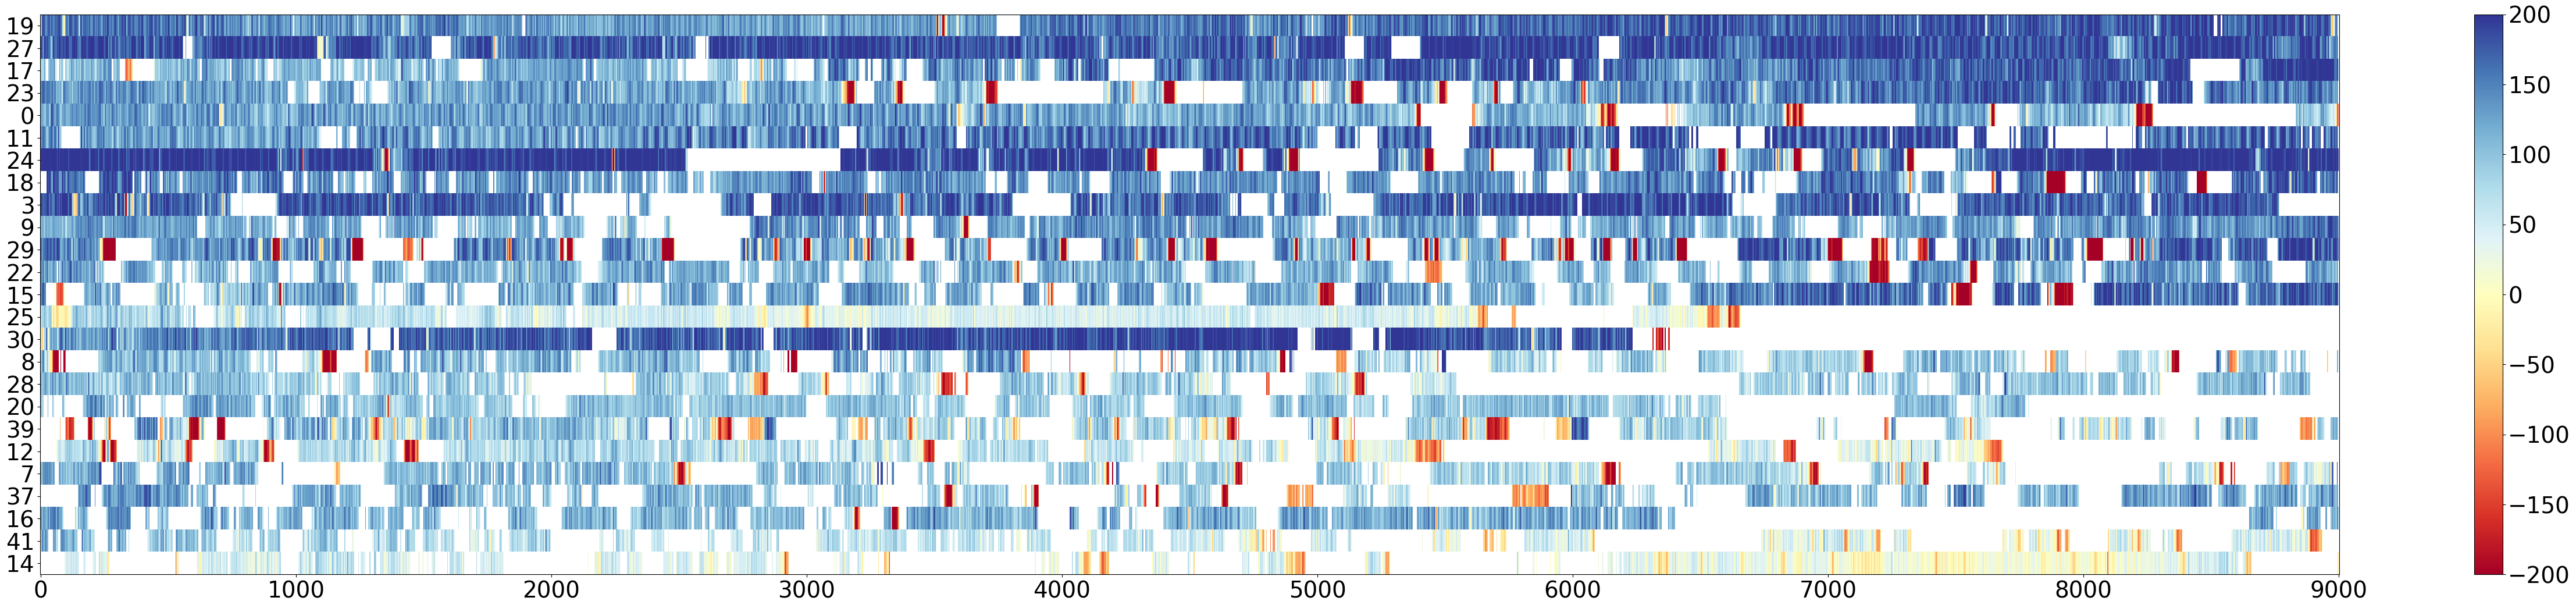

did the excel code
/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/plots/for_source_data_check/avsv9_sep_uncorr_him5.eps


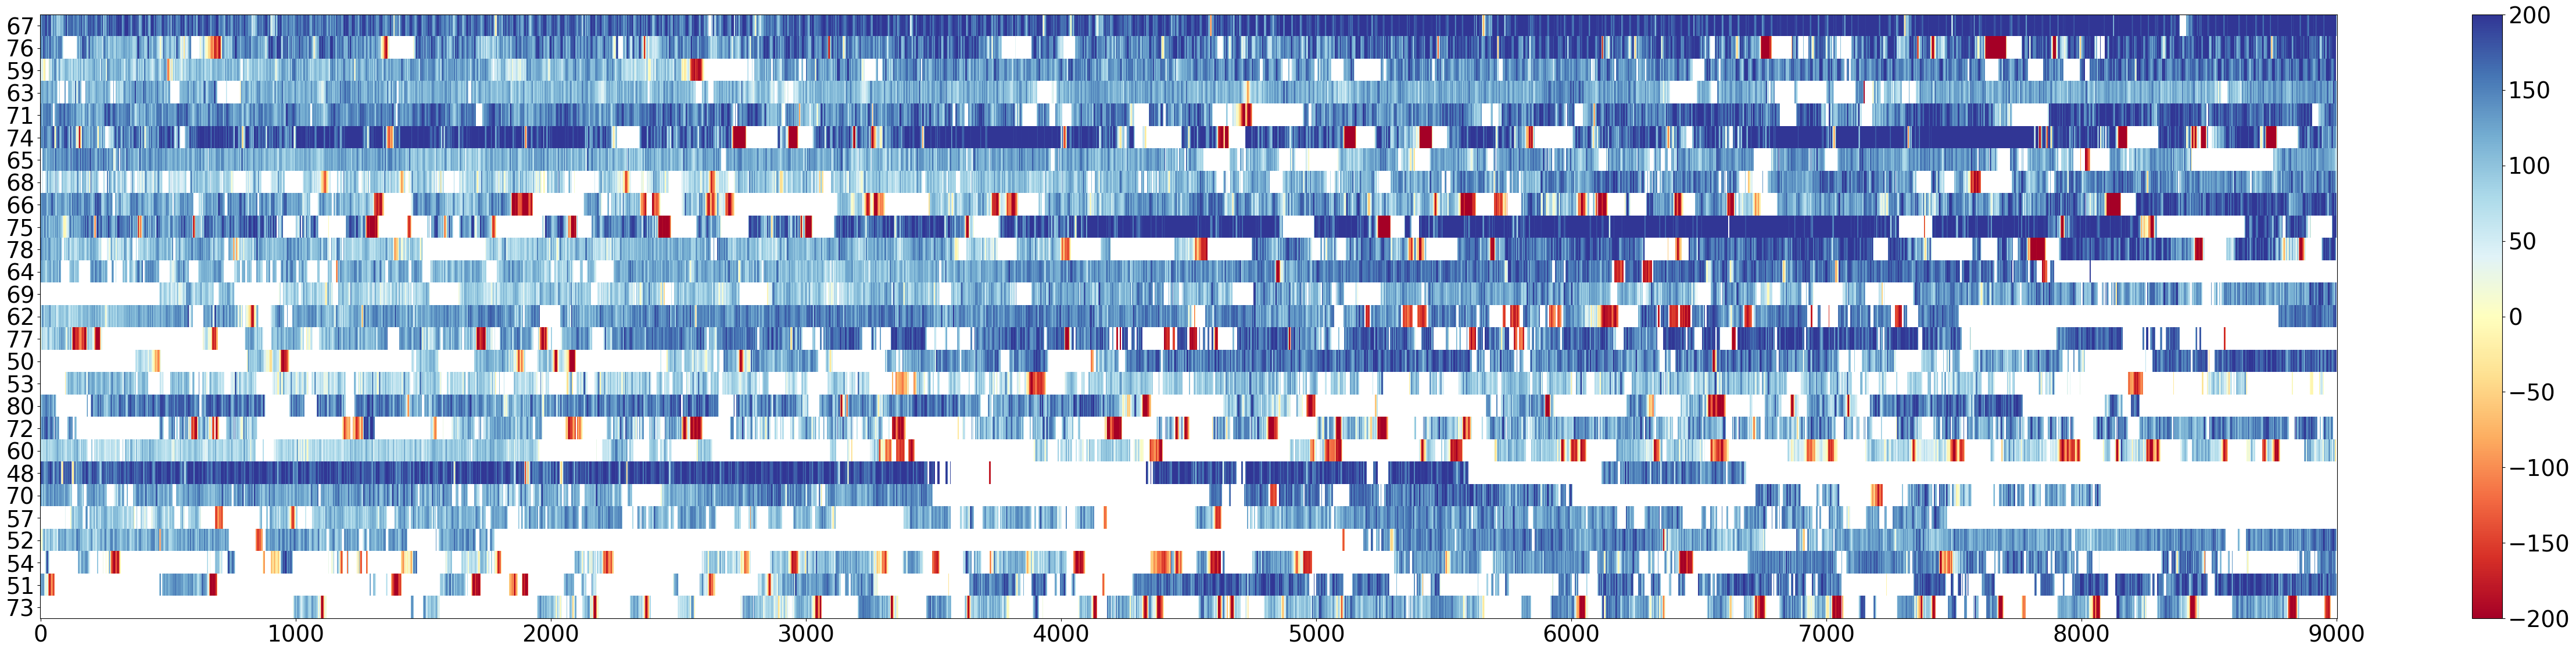

did the excel code
/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/plots/for_source_data_check/sexc9_sep_uncorr_him5.eps


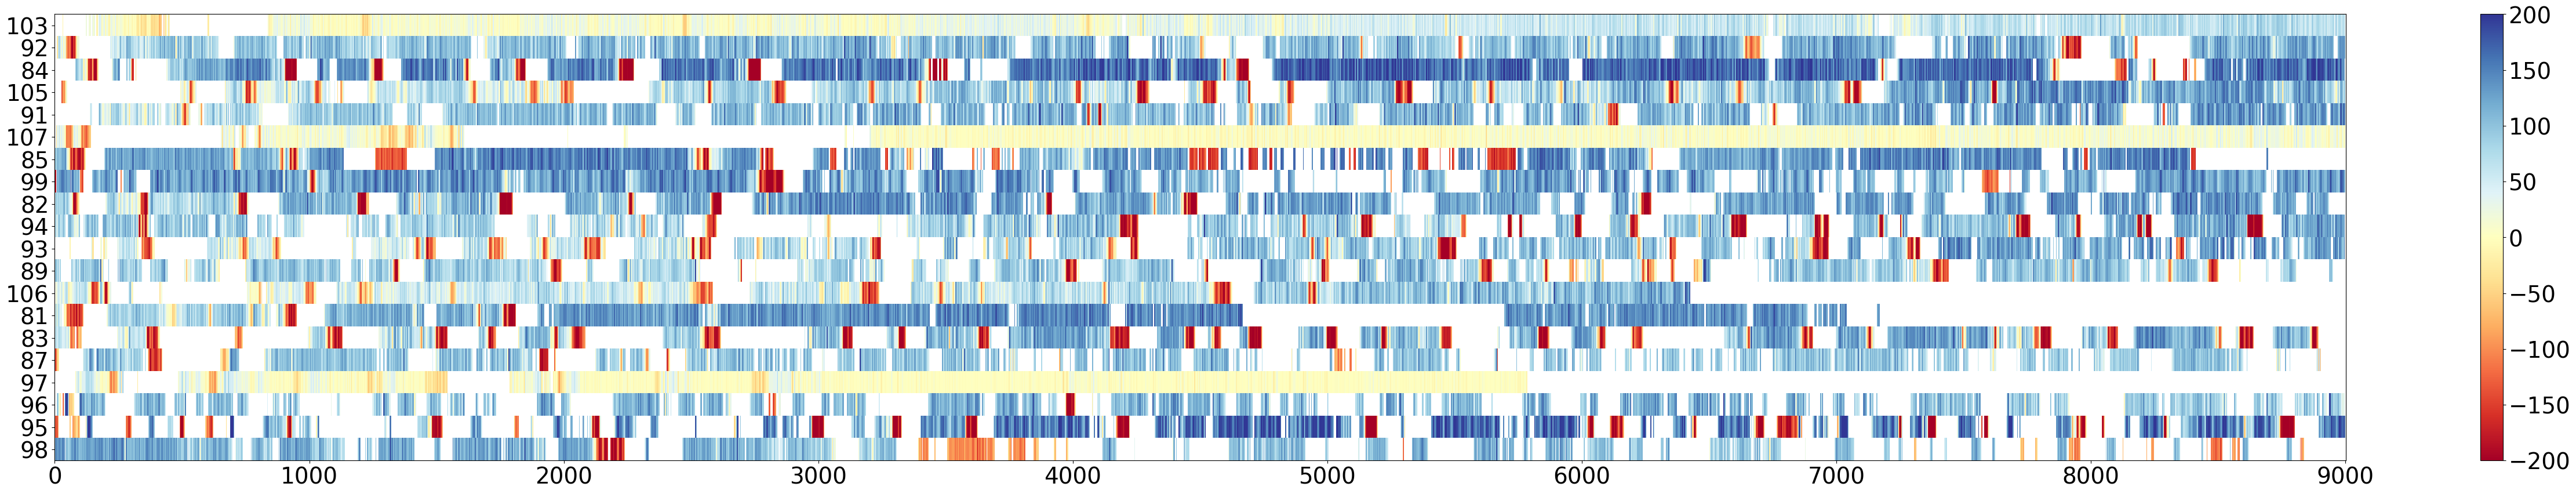

did the excel code


In [16]:
# set which dataset using
data_df = data_df_OG
# gf_per_worm
output_dir = "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/post-conditioning/him5/plots/for_source_data_check/"
#

# "/home/Documents/neuroUCL/phd/current/project/tierpsy stuff for tracking and reversals/him5/plots/plots_sorted_heatmaps_corrected misheads+newdata_dec29/"

parameters_of_analysis = "9_sep_uncorr_him5"
min_heatmap_val = -200
max_heatmap_val = 200
plot_fontsize = 28

calculate_and_heatmap(
    data_df,
    gf_per_worm,
    output_dir,
    parameters_of_analysis,
    min_heatmap_val,
    max_heatmap_val,
    plot_fontsize,
)

In [ ]:
data_df["unique_id"][data_df["cond"] == "mock"].unique()

In [ ]:
! python --version